In [29]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.cross_validation import KFold # old version

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Needed to show plots inline for notebooks
%matplotlib inline

In [2]:
Salary = pd.read_csv('./Kaggle_Salary.csv')

# Drop two useless columns
Salary.drop(['Unnamed: 0','index'], axis=1,inplace=True)
Salary.drop([0],inplace=True)
print(Salary.shape)
Salary.head()

(15429, 395)


/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
4,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,Academics/Education,...,-1,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1
5,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,Other,...,-1,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [3]:
# See how many null values are in each column
# Here we only deal with those colunmns that has null values more than zero but fewer that 1% of all data
less_001 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (NullNum > 0) & (0.01 * Salary.shape[0] > NullNum):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            less_001.append(col)
print("We drop nan rows in the below columns:",less_001)

for col in less_001:
    Salary.dropna(subset=[col],inplace=True)

We drop nan rows in the below columns: ['Q5', 'Q8']


In [4]:
more_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if 0.5 * Salary.shape[0] < NullNum:
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            more_050.append(col)
print("We drop these columns because large part of the data is missing:",more_050)

for col in more_050:
    Salary.drop([col], axis=1,inplace=True)

We drop these columns because large part of the data is missing: ['Q37']


In [5]:
between_020_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0]) < NullNum and (NullNum < 0.5 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_020_050.append(col)
print("We set nans in these columns as 'Unknown':",between_020_050)

for col in between_020_050:
    Salary.loc[Salary[col].isnull(),col] = 'Unknown'

We set nans in these columns as 'Unknown': ['Q17', 'Q20', 'Q22', 'Q32', 'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q43', 'Q46', 'Q48']


In [6]:
between_001_020 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0] > NullNum) and (NullNum >= 0.01 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_001_020.append(col)
print("We use modes in these columns to replace nan value:",between_001_020)
for col in between_001_020:
    Salary[col].fillna(Salary[col].mode()[0],inplace=True)

We use modes in these columns to replace nan value: ['Q10', 'Q12_MULTIPLE_CHOICE', 'Q18', 'Q23', 'Q24', 'Q25', 'Q26']


In [7]:
ALLCOL = Salary.columns.tolist()
def select_col(condition, allcol=ALLCOL):
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected

In [8]:
DummyCols = ['Q1','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE',\
            'Q17','Q18','Q20','Q23','Q26','Q32','Q39_Part_1', 'Q39_Part_2',\
             'Q40','Q48']

In [9]:
for col in DummyCols:
    Salary = pd.get_dummies(data=Salary, columns=[col])

In [10]:
# print(Salary['Q3'].value_counts())
val_counts = Salary['Q3'].value_counts()
value_mask = Salary['Q3'].isin(val_counts.index[val_counts < 50])
Salary.loc[value_mask,'Q3'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q3'])

In [11]:
# print(Salary['Q22'].value_counts())
val_counts = Salary['Q22'].value_counts()
value_mask = Salary['Q22'].isin(val_counts.index[val_counts < 200])
Salary.loc[value_mask,'Q22'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q22'])

In [12]:
def Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        if '+' in value:
            a = value.split('+')
            return float(a[0])
        else:
            return value
    else:
        return value

In [13]:
# Salary[select_col('Q2')]
Salary['Q2_NORMAL'] = Salary['Q2'].apply(Range_Normalize)
Salary.drop(['Q2'],axis=1,inplace=True)

In [14]:
# Salary[select_col('Q8')]
Salary['Q8_NORMAL'] = Salary['Q8'].apply(Range_Normalize)
Salary.drop(['Q8'],axis=1,inplace=True)

In [15]:
# Salary[select_col('Q24')]
def Q24Range_Normalize(value):
    mapdict = {'I have never written code and I do not want to learn':-1,
               'I have never written code but I want to learn':0,'< 1 year':0.5,
              '1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,
               '20-30 years':25,'30-40 years':35,'40+ years':40}
    return mapdict[value]
# Salary[select_col('Q2')]
Salary['Q24_NORMAL'] = Salary['Q24'].apply(Q24Range_Normalize)
Salary.drop(['Q24'],axis=1,inplace=True)

In [16]:
# Salary[select_col('Q25')]
Salary['Q25'].unique()
def Q25Range_Normalize(value):
    mapdict = {'I have never studied machine learning and I do not plan to':-1,
               'I have never studied machine learning but plan to learn in the future':0,
               '< 1 year':0.5,'1-2 years':1.5,'2-3 years':2.5,'3-4 years':3.5,'4-5 years':4.5,
               '5-10 years':7.5,'10-15 years':12.5,'20+ years':20}
    return mapdict[value]

Salary['Q25_NORMAL'] = Salary['Q25'].apply(Q25Range_Normalize)
Salary.drop(['Q25'],axis=1,inplace=True)

In [17]:
def Q41Range_Normalize(value):
    mapdict = {'Very important':10,
               'Slightly important':5,
               'No opinion; I do not know':2,
               'Unknown':0,
               'Not at all important':-10}
    return mapdict[value]

Salary.loc[Salary['Q41_Part_1'].isnull(),'Q41_Part_1'] = 'Unknown'
Salary.loc[Salary['Q41_Part_2'].isnull(),'Q41_Part_2'] = 'Unknown'
Salary.loc[Salary['Q41_Part_3'].isnull(),'Q41_Part_3'] = 'Unknown'

Salary['Q41_Part_1_NORMAL'] = Salary['Q41_Part_1'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_1'],axis=1,inplace=True)
Salary['Q41_Part_2_NORMAL'] = Salary['Q41_Part_2'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_2'],axis=1,inplace=True)
Salary['Q41_Part_3_NORMAL'] = Salary['Q41_Part_3'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_3'],axis=1,inplace=True)

In [18]:
def Q43Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        elif value == "0":
            return 0
        else:
            return float("nan")
    else:
        return value
Salary['Q43_NORMAL'] = Salary['Q43'].apply(Q43Range_Normalize)
Salary.drop(['Q43'],axis=1,inplace=True)
Salary['Q43_NORMAL'].fillna(Salary['Q43_NORMAL'].mode()[0],inplace=True)

Salary['Q46_NORMAL'] = Salary['Q46'].apply(Q43Range_Normalize)
Salary.drop(['Q46'],axis=1,inplace=True)
Salary['Q46_NORMAL'].fillna(Salary['Q46_NORMAL'].mode()[0],inplace=True)

In [19]:
# Salary[select_col('Q11')]
import math
def Binarize(value):
    if isinstance(value,str):
        return 1
    else:
        if value == 0 or math.isnan(value):
            return 0
        else:
            return 1
def binarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(Binarize)

In [20]:
NormalCols = select_col('Q11_Part') + select_col('Q13_Part') + \
select_col('Q14_Part') + select_col('Q15_Part') + select_col('Q16_Part')\
+ select_col('Q19_Part') + select_col('Q21_Part') + select_col('Q27_Part')\
+ select_col('Q28_Part') + select_col('Q29_Part') + select_col('Q30_Part') +\
select_col('Q31_Part') + select_col('Q33_Part') + select_col('Q34_Part') +\
select_col('Q36_Part') + select_col('Q38_Part') + select_col('Q42_Part') + \
select_col('Q44_Part') + select_col('Q45_Part') + select_col('Q47_Part') + \
select_col('Q49_Part') + select_col('Q50_Part') 

In [21]:
binarize_col(NormalCols)

In [22]:
import math
def TBinarize(value):
    if isinstance(value,str):
        return float(value)
    else:
        if math.isnan(value):
            return -1
        else:
            return value
def Tbinarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(TBinarize)

Tbinarize_col(select_col('Q34_Part'))
Tbinarize_col(select_col('Q35_Part'))

In [23]:
for col in Salary.columns: 
    if Salary[col].isna().any():
        print(col)

In [24]:
for col in Salary.columns:
    if isinstance(Salary.loc[1,col],str):
        Salary[col] = Salary[col].apply(lambda x:float(x))

In [25]:
for col in Salary.columns: 
    if isinstance(Salary.loc[1,col],str):
        print(col)

In [26]:
Salary.head()

,Time from Start to Finish (seconds),Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Q9,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,...,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL,Q24_NORMAL,Q25_NORMAL,Q41_Part_1_NORMAL,Q41_Part_2_NORMAL,Q41_Part_3_NORMAL,Q43_NORMAL,Q46_NORMAL
1,434.0,-1.0,0.0,-1.0,18668.0,0,0,0,0,0,...,0,32.0,7.5,0.0,0.0,0,0,0,0.0,15.0
2,718.0,-1.0,-1.0,-1.0,2726.0,1,0,0,0,0,...,1,32.0,0.5,7.5,0.5,10,10,10,5.0,15.0
3,731.0,-1.0,-1.0,-1.0,682.0,0,0,0,0,0,...,0,23.0,0.5,7.5,2.5,-10,5,10,25.0,25.0
4,959.0,-1.0,1.0,-1.0,11957.0,0,0,0,0,0,...,0,37.0,12.5,0.5,0.5,5,5,10,5.0,0.0
5,1758.0,-1.0,2.0,1.0,2696.0,0,1,0,0,0,...,0,19.5,0.5,0.5,0.5,10,10,10,0.0,15.0


In [35]:
Salary.rename(columns={"Q9": "Yearly_compensation"},inplace=True)

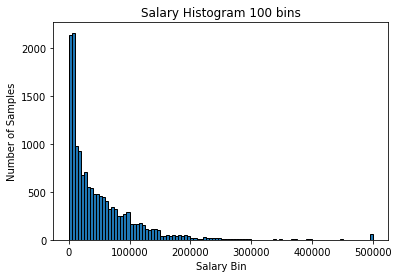

In [36]:
%matplotlib inline

plt.hist(Salary['Yearly_compensation'], bins=100, edgecolor='black')
plt.title("Salary Histogram 100 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()